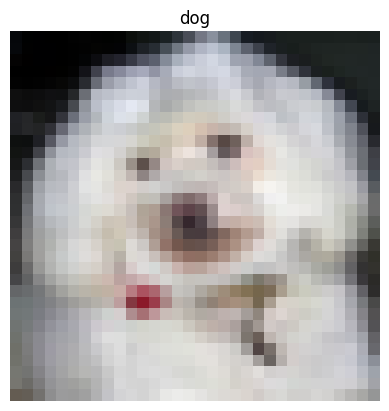

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import time
import random

# from GEM.gem import *
from GEM.args import *

from cifar import load_cifar10_data, split_into_classes, get_class_indexes 

# import quadprog

import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory

# CIFAR-10

In [2]:
# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)

# PRETRAINED MODEL

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
# make cuda available if available

from cifar import load_cifar10_data, show_image

# we want to create a resnet 18 model for 32x32 images
# avoid upscaling, the model will take 32x32 images on input as opposed to 224x224

initialisation = time.time()

class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        self.resnet.conv1 = torch.nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.resnet.bn1 = torch.nn.BatchNorm2d(128)
        # change number of blocks per layer
        self.resnet.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128)
        )
        self.resnet.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(256)
        )
        self.resnet.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(512)
        )
        self.resnet.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024)
        )
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(1024, 10)
        # start with 5 classes and add more as needed
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
model = ResNet18CIFAR()
model.eval

Using cache found in C:\Users\Tom/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.eval of ResNet18CIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), strid

In [4]:
# turn the data into a tensor
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels)

# Define the number of classes in your dataset
num_classes = 10
# Initialize counters for each class
class_correct = [0] * num_classes
class_total = [0] * num_classes

print("||===================START CLASS-BY-CLASS ACCURACY=================||")

# Move tensors to GPU if available
if torch.cuda.is_available():
    test_data_tensor = test_data_tensor.cuda()
    test_labels_tensor = test_labels_tensor.cuda()

# Test the model
with torch.no_grad():
    for i in range(0, len(test_data), 1000):
        # Get the input and output
        img = test_data_tensor[i:i + 1000]
        label = test_labels_tensor[i:i + 1000]
        
        model = model.cuda()

        # Get the prediction
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

        # Update per-class counters
        for lbl, pred in zip(label, predicted):
            class_total[lbl.item()] += 1
            if lbl.item() == pred.item():
                class_correct[lbl.item()] += 1

        del img

# Print overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total) * 100
print(f"|| Overall Test Accuracy: {overall_accuracy:.2f}% ||")

# Print accuracy for each class
for cls in range(num_classes):
    if class_total[cls] > 0:
        class_accuracy = class_correct[cls] / class_total[cls] * 100
        print(f"|| Accuracy for Class {cls}: {class_accuracy:.2f}% ||")
    else:
        print(f"|| No samples for Class {cls} ||")

||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 10.77% ||
|| Accuracy for Class 0: 11.80% ||
|| Accuracy for Class 1: 8.30% ||
|| Accuracy for Class 2: 9.10% ||
|| Accuracy for Class 3: 8.80% ||
|| Accuracy for Class 4: 6.30% ||
|| Accuracy for Class 5: 7.30% ||
|| Accuracy for Class 6: 10.80% ||
|| Accuracy for Class 7: 16.30% ||
|| Accuracy for Class 8: 22.70% ||
|| Accuracy for Class 9: 6.30% ||


# UNLEARNING

In [ ]:
%cd /dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning/Unlearning

### Prepare Data and Model

In [ ]:
# Classes to be Unlearnt
classes_to_unlearn = [0, 1, 2, 3, 4]

In [ ]:
from collections import OrderedDict
from unlearn.scrub import train_distill, iterative_unlearn, scrub
from utils import DistillKL, AverageMeter, accuracy
from torch.utils.data import DataLoader, TensorDataset

# Convert data and labels to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).cuda()
train_labels_tensor = torch.tensor(train_labels).cuda()

test_data_tensor = torch.tensor(test_data, dtype=torch.float32).cuda()
test_labels_tensor = torch.tensor(test_labels).cuda()

# Split training data into forget and retain sets
forget_mask = torch.isin(train_labels_tensor, torch.tensor(classes_to_unlearn).cuda())
retain_mask = ~forget_mask

# Get the indices of the forget and retain subsets
forget_indices = forget_mask.nonzero(as_tuple=True)[0]
retain_indices = retain_mask.nonzero(as_tuple=True)[0]

# Create the forget and retain datasets using the indices
forget_dataset = TensorDataset(train_data_tensor[forget_indices], train_labels_tensor[forget_indices])
retain_dataset = TensorDataset(train_data_tensor[retain_indices], train_labels_tensor[retain_indices])
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
data_loaders = OrderedDict(
    forget = DataLoader(forget_dataset, batch_size=64, shuffle=True),
    retain = DataLoader(retain_dataset, batch_size=64, shuffle=True),
    test =  DataLoader(test_dataset, batch_size=64, shuffle=False)
)


In [ ]:
# Move the model to device
import copy
umodel = copy.deepcopy(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
umodel.to(device)

### DEFINE ALGORITHM HYPERPARAMETERS

In [ ]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

class Args:
    def __init__(self):
        self.unlearn_lr = 0.0001         # Learning rate for unlearning
        self.momentum = 0.9
        self.weight_decay = 0.0005
        self.dataset = ''      # Change as needed
        self.num_classes = 10         # Number of classes in the dataset
        self.batch_size = 64
        self.print_freq = 10
        self.warmup = 0               # Number of warmup epochs
        self.imagenet_arch = False    # Set to True if using ImageNet architecture
        self.seed = 42       
        
        # SCRUB SPECIFIC
        self.kd_T = 1
        self.msteps = 1
        self.gamma = 10
        self.beta = 1


        # Add the following attributes to ensure compatibility
        self.decreasing_lr = '50,75'  # Comma-separated epochs where LR decays
        self.rewind_epoch = 0         # Epoch to rewind to; set to 0 if not using rewinding
        self.rewind_pth = ''          # Path to the rewind checkpoint
        self.gpu = 0                  # GPU ID to use; adjust as needed
        self.surgical = False         # Whether to use surgical unlearning
        self.unlearn = 'SCRUB'      # Unlearning method, e.g., 'retrain'
        self.choice = []              # Layers to unlearn surgically; list of layer names
        self.unlearn_epochs = 20     # Number of epochs for unlearning
        self.epochs = 100   

args = Args()

### Apply Unlearning Method

In [ ]:
import unlearn
unlearn_method = unlearn.get_unlearn_method(args.unlearn)
if args.unlearn == 'SCRUB':
    model_s = copy.deepcopy(umodel)
    model_t = copy.deepcopy(umodel)
    module_list = nn.ModuleList([model_s, model_t])
    unlearn_method(data_loaders, module_list, criterion, args)
    umodel = module_list[0]
else:
    unlearn_method(data_loaders, umodel, criterion, args)

### Evaluate Model

In [ ]:
# Initialize counters for each class
from Unlearning import utils
from Unlearning.trainer.val import validate


class_correct = [0] * 10
class_total = [0] * 10

# Evaluate the unlearned model
umodel.eval()

with torch.no_grad():
    for inputs, labels in data_loaders["test"]:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        outputs = umodel(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts for each class
        for label, prediction in zip(labels, predicted):
            class_total[label.item()] += 1
            if label.item() == prediction.item():
                class_correct[label.item()] += 1

# Print overall accuracy
overall_accuracy = 100 * sum(class_correct) / sum(class_total)
print('Overall accuracy of the unlearned model on the test data: {:.2f}%'.format(overall_accuracy))

# Print accuracy for each class
for i in range(10):
    if class_total[i] > 0:
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy for class {}: {:.2f}%'.format(i, class_accuracy))
    else:
        print('No samples for class {}'.format(i))


for name, loader in data_loaders.items():
        utils.dataset_convert_to_test(loader.dataset, args)
        val_acc = validate(loader, umodel, criterion, args)
        print(f"{name} acc: {val_acc}")
